In [1]:
#import packages

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import plotly.express as px
import folium
import json
from datetime import datetime
import plotly.graph_objects as go
from shapely import geometry

In [35]:
index_stats_df = pd.read_csv("../CF_pond_app/Data/ndwi_stats_2021_24.csv")
cf_ponds_df = gpd.read_file("../CF_pond_app/Data/combined_v1.geojson").to_crs(4326)
cf_ponds_df = cf_ponds_df.rename(columns={'pond name': 'Pond name'})

In [78]:
index_stats_df["time"]= pd.to_datetime(index_stats_df["time"])
ndwi_data = index_stats_df[index_stats_df["spectral_index"]=="NDWI"]
ndwi_data = ndwi_data.reset_index()
ndwi_data = ndwi_data.set_index("time")
ndwi_ipt = ndwi_data.groupby("zone")["mean"].resample('5D').mean().interpolate('linear').reset_index()

ndwi_ipt = ndwi_ipt.set_index("time")
ndwi_ipt_rm = ndwi_ipt.groupby("zone").rolling(5).mean().reset_index()

ndwi_ipt_rm = ndwi_ipt_rm.set_index("time")
ndwi_ipt_rm["end_date"] = ndwi_ipt_rm.index
ndwi_ipt_rm["start_date"] = ndwi_ipt_rm["end_date"].shift(1)

# ndwi_ipt_rm = ndwi_ipt_rm.set_index("time")

ndwi_ipt_rm["status"] = ndwi_ipt_rm["mean"].apply(lambda x : "fallow" if x <-0.05 else "active")
ndwi_ipt_rm["event"] = ndwi_ipt_rm["status"].apply(lambda x : False if x=="active" else True)
ndwi_ipt_rm['time'] = pd.to_datetime(ndwi_ipt_rm.index)

# data_ponds = data_ponds.set_index("time")
ndwi_ipt_rm['time_of_last_event'] = ndwi_ipt_rm['time'].where(ndwi_ipt_rm['event']).ffill()

cons_active_stats_df = pd.DataFrame()

for time in ndwi_ipt_rm[(ndwi_ipt_rm.time.dt.year>=2022)].time.unique():
    ndwi_time_fil = ndwi_ipt_rm[ndwi_ipt_rm.time==time]
    temp_df = ndwi_time_fil.groupby("status")["zone"].count().reset_index().rename(columns={"zone":"n_ponds"})
    temp_df["time"] = time
    cons_active_stats_df=cons_active_stats_df.append(temp_df)

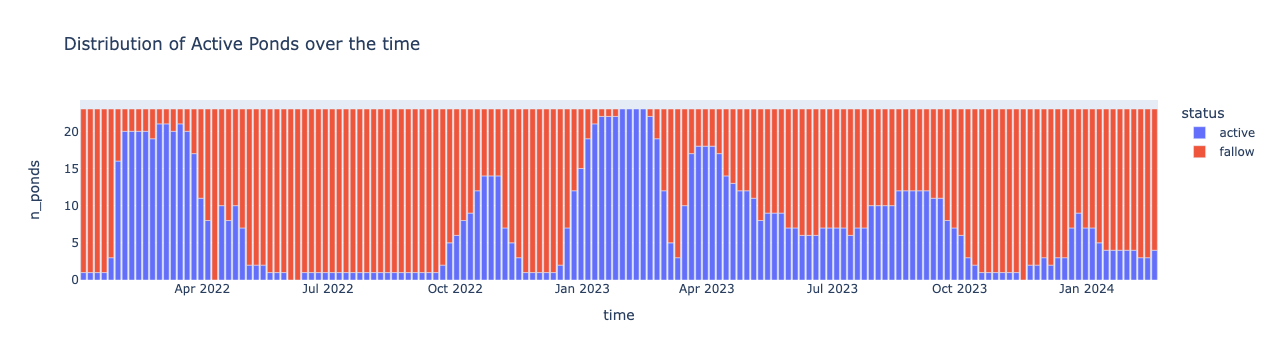

In [79]:
### View 1 : Distribution of Active and Fallow Ponds

fig = px.bar(cons_active_stats_df, x='time', y='n_ponds',
              color='status',
              height=500,
             title="Distribution of Active Ponds over the time")

fig.show()


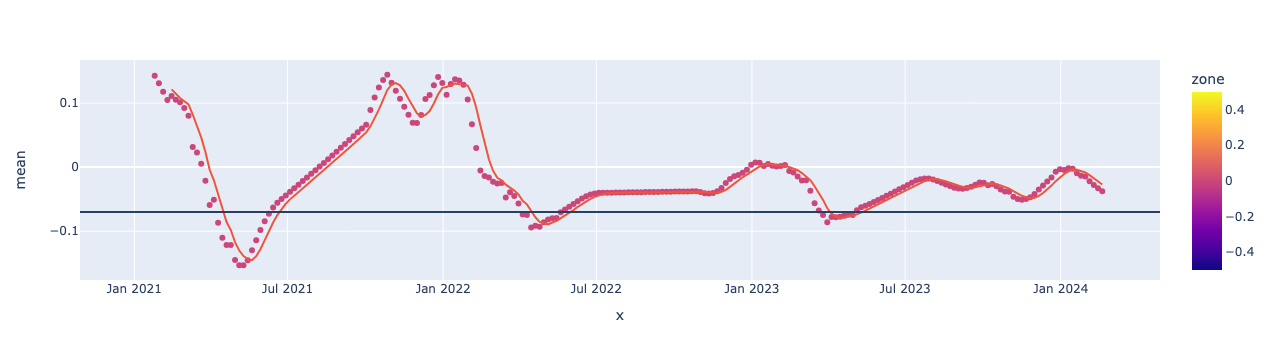

In [113]:
fig = px.scatter(ndwi_ipt_rm[ndwi_ipt_rm["zone"]==0], x=ndwi_ipt_rm[ndwi_ipt_rm["zone"]==20].time, y="mean", color='zone',trendline="rolling", trendline_options=dict(window=5))

fig.update_layout(shapes=[
dict(
  type= 'line',
  yref= 'y', y0= -0.07, y1= -0.07,   # adding a horizontal line at Y = 1
  xref= 'paper', x0= 0, x1= 1
     ) 
])

fig.show()

In [93]:
select = ndwi_ipt_rm[(ndwi_ipt_rm["zone"]==20) & (ndwi_ipt_rm.time.dt.year>=2022)]

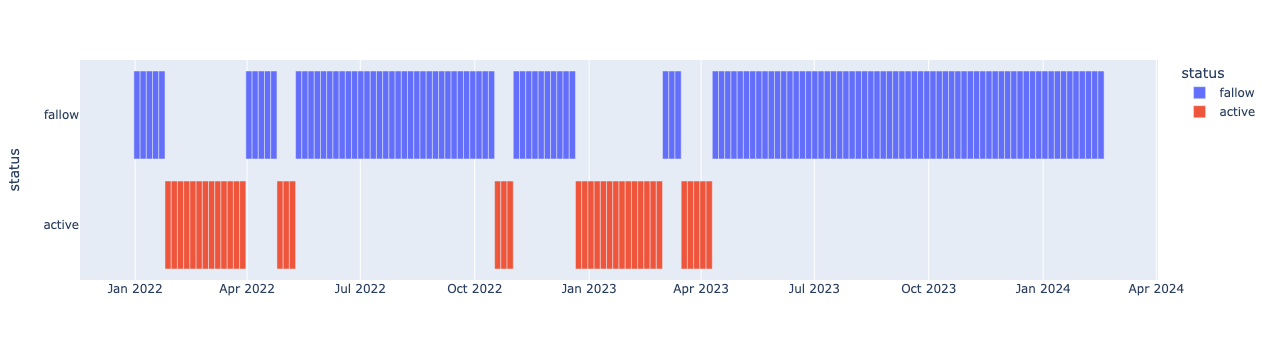

In [94]:
fig = px.timeline(select, x_start="start_date", x_end="end_date", y="status",color="status")
# fig.update_yaxes(autorange="reversed")
fig.show()

In [95]:
### Timeline - Readiness

def get_harvest_readiness(doc):
    if doc in range(40,61):
        return "40-60 DoC"
    elif doc in range(61,90):
        return "61-90 DoC"
    elif doc in range(91,120):
        return "91-120 DoC"
    elif doc > 120 :
        return ">120 DoC"
    elif doc in range(5,41) :
        return "Early Stage Culture"
    else :
        return "Dry"


In [122]:
def get_readiness_df(ndwi_ipt_rm):
    df_pnds_profile = ndwi_ipt_rm.copy()

    df_pnds_profile["proj_DoC"]= (df_pnds_profile.index-df_pnds_profile["time_of_last_event"]).dt.days
    
    df_pnds_profile_10d = df_pnds_profile[df_pnds_profile.index=="2024-02-19"]
    df_pnds_profile_10d["proj_DoC_10d"]= df_pnds_profile_10d["proj_DoC"].apply(lambda x : x+10 if x>0 else 0)
    df_pnds_profile_10d["proj_DoC_20d"]= df_pnds_profile_10d["proj_DoC"].apply(lambda x : x+20 if x>0 else 0)
    df_pnds_profile_10d["harvest_readiness_10d"] = df_pnds_profile_10d["proj_DoC_10d"].apply(lambda x : get_harvest_readiness(x))
    df_pnds_profile_10d["harvest_readiness_20d"] = df_pnds_profile_10d["proj_DoC_20d"].apply(lambda x : get_harvest_readiness(x))
    
    df_grouped_hr_10d = df_pnds_profile_10d.groupby("harvest_readiness_10d")["zone"].count().rename("n_Ponds").reset_index()
    df_grouped_hr_20d = df_pnds_profile_10d.groupby("harvest_readiness_20d")["zone"].count().rename("n_Ponds").reset_index()

    df_grouped_hr_10d = df_grouped_hr_10d[df_grouped_hr_10d["harvest_readiness_10d"].isin(["40-60 DoC","61-90 DoC","91-120 DoC"])]
    df_grouped_hr_20d = df_grouped_hr_20d[df_grouped_hr_20d["harvest_readiness_20d"].isin(["40-60 DoC","61-90 DoC","91-120 DoC"])]

    return df_pnds_profile,df_pnds_profile_10d,df_grouped_hr_10d,df_grouped_hr_20d

In [123]:
df,df_pnds_profile_10d,a,b = get_readiness_df(ndwi_ipt_rm)

In [116]:
df_pnds_profile_10d

,zone,mean,end_date,start_date,status,event,time,time_of_last_event,proj_DoC,proj_DoC_10d,proj_DoC_20d,harvest_readiness_10d,harvest_readiness_20d
time,,,,,,,,,,,,,
2024-02-19,0,-0.037811,2024-02-19,2024-02-14,active,False,2024-02-19,2023-11-16,95.0,105.0,115.0,91-120 DoC,91-120 DoC
2024-02-19,1,-0.060158,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry
2024-02-19,2,-0.026518,2024-02-19,2024-02-14,active,False,2024-02-19,2023-12-16,65.0,75.0,85.0,61-90 DoC,61-90 DoC
2024-02-19,3,-0.067593,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry
2024-02-19,4,-0.084155,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry
2024-02-19,5,-0.146306,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry
2024-02-19,6,-0.153214,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry
2024-02-19,7,-0.165266,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry
2024-02-19,8,-0.168664,2024-02-19,2024-02-14,fallow,True,2024-02-19,2024-02-19,0.0,0.0,0.0,Dry,Dry


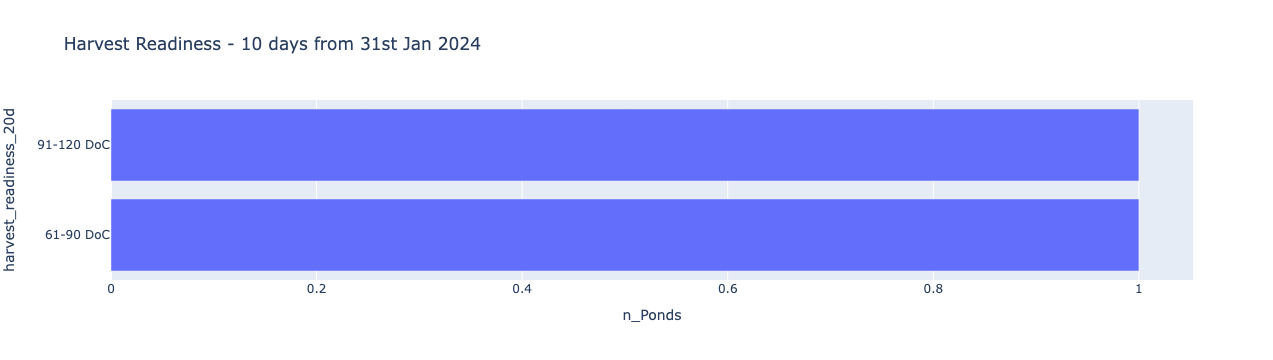

In [117]:
px.bar(b, x="n_Ponds", y="harvest_readiness_20d", orientation='h',title="Harvest Readiness - 10 days from 31st Jan 2024")

In [156]:
selected = df[(df["zone"]==2) & (df.time.dt.year>=2022)]

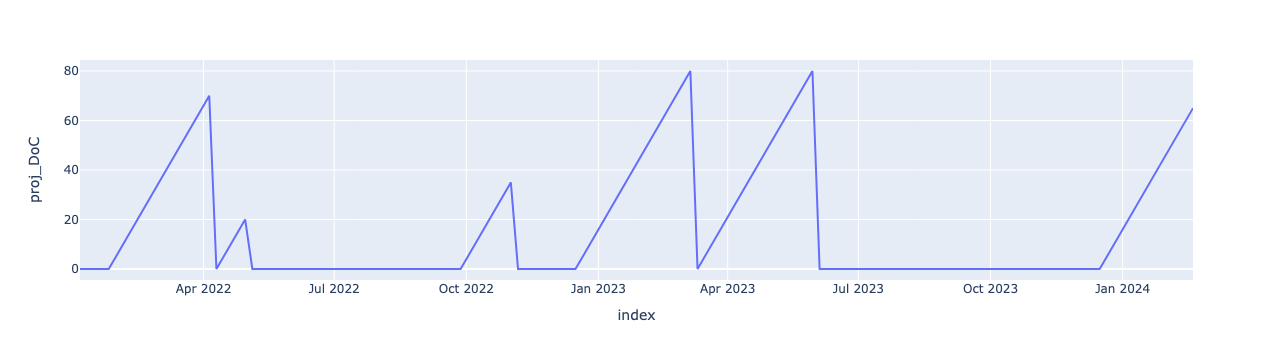

In [157]:
fig = px.line(selected, x=selected.index, y="proj_DoC",)
fig.show()

In [159]:
def compress(lst):
    res = []
    i = 0
    ind = 0
    while ind < len(lst):
        letter_count = 0
        while i < len(lst) and lst[i] == lst[ind]:
            letter_count += 1
            i +=1
        res.append((lst[ind], letter_count))
        ind += letter_count
    return res

def get_pond_practice_df(list_event):
    
    list_cycles = []
    for idx in range(0,len(list_event)):
        if idx>0:
            event , duration = list_event[idx]
            event_p , duration_p = list_event[idx-1]
            # event_f , duration_f = list_event[idx]


            # print(event,duration)
            # print(event_p , duration_p)
            if (event_p == "F") :
                if (duration_p>15):
                    if duration<=120:
                        list_cycles.append((event_p,duration_p,event,duration,"Dried Before Stocking","Good Active DoC cycle"))
                    else :
                        list_cycles.append((event_p,duration_p,event,duration,"Dried Before Stocking","Possible Crop Rotation"))

                else :
                    if duration<=120:
                        list_cycles.append((event_p,duration_p,event,duration,"Inadequate Drying Before Stocking","Good Active DoC cycle"))
                    else :
                        list_cycles.append((event_p,duration_p,event,duration,"Inadequate Drying Before Stocking","Possible Crop Rotation"))
                        
    pond_practice_df = pd.DataFrame(list_cycles,columns=["Fallow","FallowPeriod","Active","ActivePeriod","Drying Practice","Culture_Practice"])
    pond_practice_df["Cycle"] = pond_practice_df.index+1
    return pond_practice_df


def get_pond_practice_all(ndwi_ipt_rm):
    pond_practice_df_all = pd.DataFrame()

    for pond_no in ndwi_ipt_rm["zone"].unique():
        data_seq = ndwi_ipt_rm[["zone","time","status"]]
        data_seq = data_seq[data_seq["zone"]==pond_no]
        data_seq["status_flag"] = data_seq["status"].apply(lambda x : "F" if x=="fallow" else "A")
        data_seq_1 = data_seq[["time","status_flag"]].set_index("time").resample("1D").last().ffill()
        list_event = compress(data_seq_1["status_flag"])
        pond_practice_df = get_pond_practice_df(list_event)
        pond_practice_df["zone"] = pond_no
        pond_practice_df_all = pond_practice_df_all.append(pond_practice_df)
    pond_practice_df_all = pond_practice_df_all.reset_index()
    return pond_practice_df_all

pond_practice_df_all = get_pond_practice_all(ndwi_ipt_rm)

latest_pond_practive = pond_practice_df_all.groupby("zone").tail(1)

dry_prac_df = latest_pond_practive.groupby("Drying Practice")["Culture_Practice"].count().rename("%Ponds").reset_index().groupby(["Drying Practice"]).sum().transform(lambda x: x/np.sum(x)*100).reset_index()

cul_prac_df = latest_pond_practive.groupby("Culture_Practice")["Culture_Practice"].count().rename("%Ponds").reset_index().groupby(["Culture_Practice"]).sum().transform(lambda x: x/np.sum(x)*100).reset_index()

In [161]:
dry_prac_df

,Drying Practice,%Ponds
0,Dried Before Stocking,82.608696
1,Inadequate Drying Before Stocking,17.391304


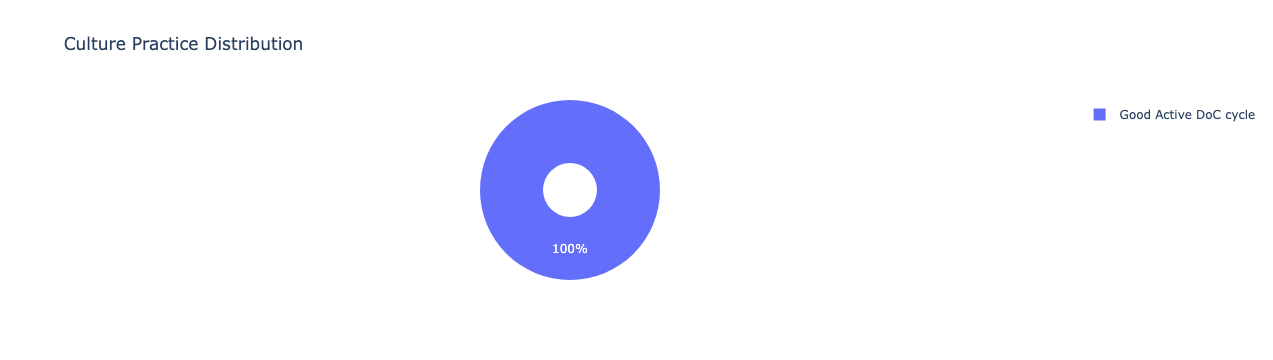

In [162]:
px.pie(cul_prac_df,values='%Ponds', names="Culture_Practice",hole=.3,title="Culture Practice Distribution")

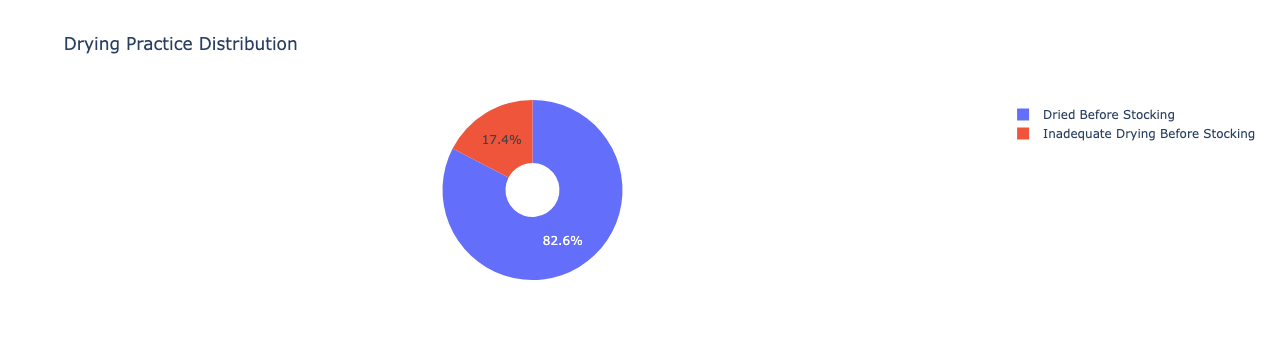

In [163]:
px.pie(dry_prac_df,values='%Ponds', names="Drying Practice",hole=.3,title="Drying Practice Distribution")

In [38]:
tooltip1=folium.features.GeoJsonTooltip(fields=['Pond name'])

In [39]:
import folium
map_test = folium.Map(location=[16.8336139,82.1103954],tiles="openstreetmap",   zoom_start=16)


# data = gpd.GeoDataFrame(nellore_ponds_df[nellore_ponds_df["Days of Culture"]!=""])
# data = data.set_crs("epsg:4326")

folium.GeoJson(data=cf_ponds_df[['geometry','Pond name']],
               style_function = lambda x : {'color': "red",'fillColor': '#00000000',"fill_opacity":1}
               ,name='Ponds_Inside_Study_Region1',tooltip=tooltip1
              ).add_to(map_test)

folium.TileLayer(  tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True).add_to(map_test)

folium.LayerControl().add_to(map_test)
map_test

In [168]:
import requests
def get_weather_graphs(lat,lon):
    url = "https://api.openweathermap.org/data/3.0/onecall?lat={}&lon={}&exclude=minutely&appid=32ff182db516cfc764a55ad998d76117".format(lat,lon)
    res = requests.get(url)
    data = res.json()
    weather_forecast_7 = pd.DataFrame.from_records(data["daily"])
    weather_forecast_7["temp_day"] = weather_forecast_7.temp.apply(lambda x: x["day"])
    # weather_forecast_7["temp_night"] = weather_forecast_7.temp.apply(lambda x: x["night"])
    weather_forecast_7["temp_max"] = weather_forecast_7.temp.apply(lambda x: x["max"])
    weather_forecast_7["temp_min"] = weather_forecast_7.temp.apply(lambda x: x["min"])
    weather_forecast_7["date"] = weather_forecast_7["dt"].apply(lambda x : datetime.fromtimestamp(x))
    weather_plot=weather_forecast_7[["temp_day","temp_max","temp_min","pop","date"]]
    weather_forecast_7 = weather_forecast_7.set_index("date")
    
    fig_pop = px.line(weather_plot,weather_plot.date,weather_plot["pop"]*100,title="Forecast - 7days - Precipitation")
    fig_pop.update_yaxes(title="Propability of Precipitaiton(%)")
    
    fig_temp = px.line(weather_plot,weather_plot.date,weather_plot["temp_max"]-273,title="Forecast - 7days - Temperature")
    fig_temp.update_yaxes(title="Temperature in °C")

    return fig_pop, fig_temp

In [181]:
lon,lat = 82.1104750,16.8339225

In [184]:
a,b=get_weather_graphs(lat,lon)

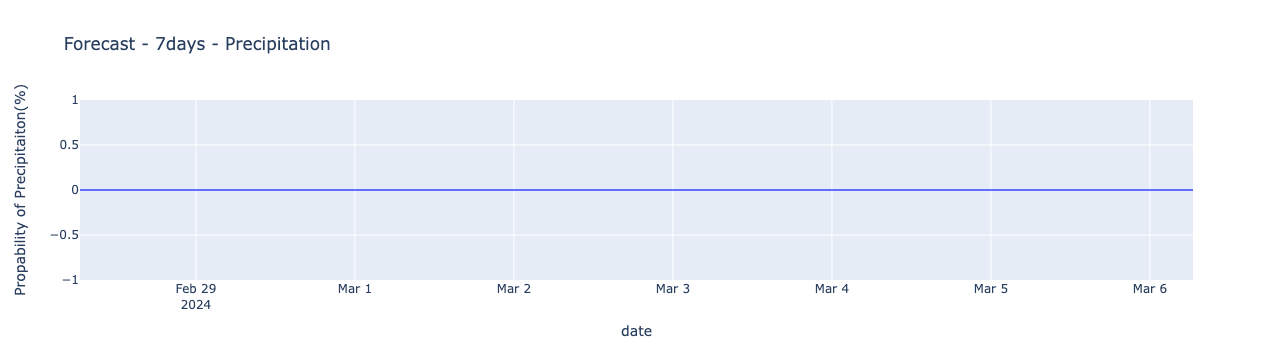

In [185]:
a

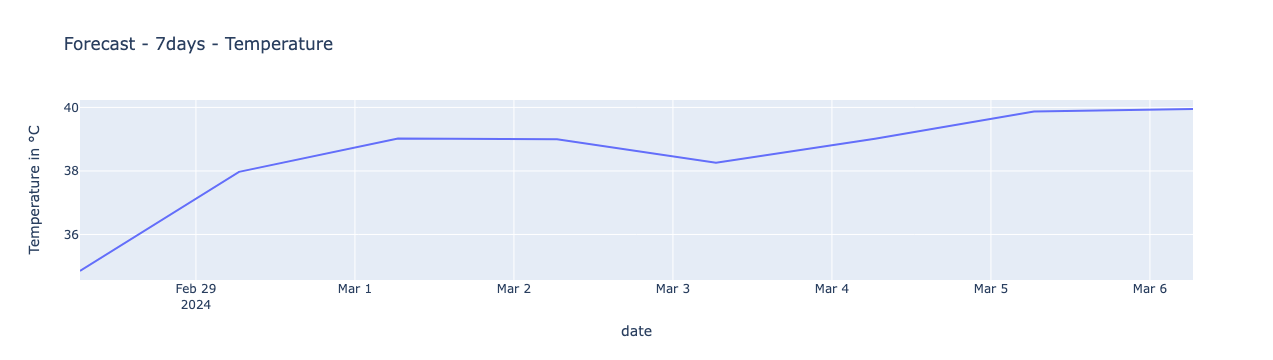

In [186]:
b